# OpenDSS run for Normally Distributed Scenarios

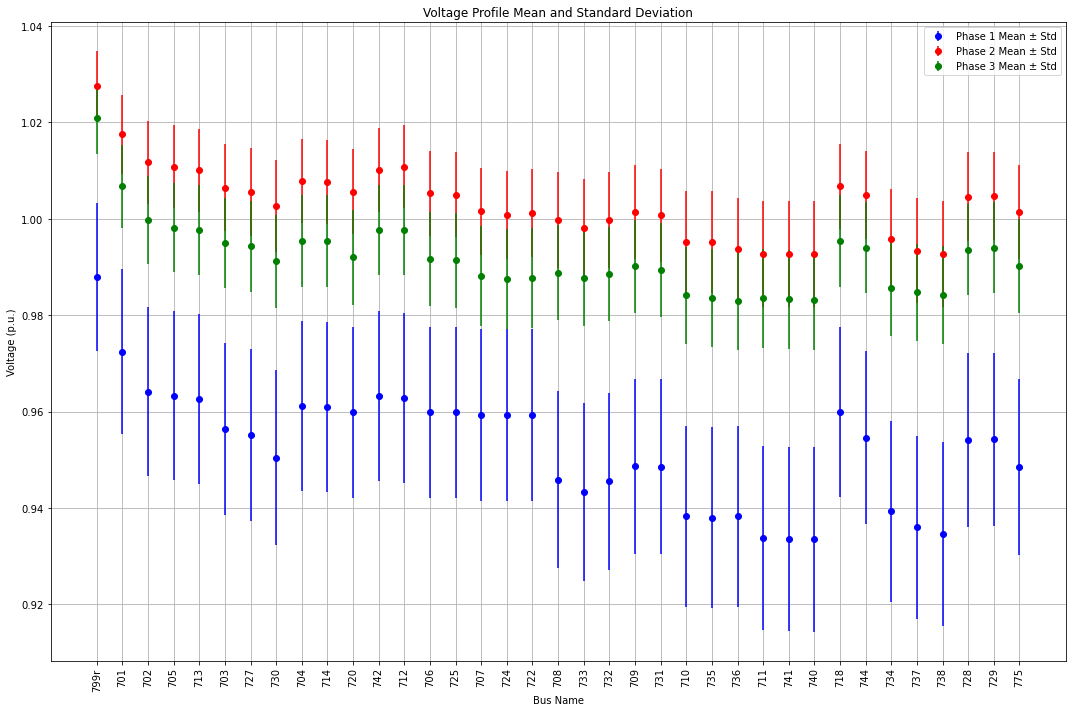

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from opendssdirect import dss

class VoltageProfileSimulator:
    def __init__(self, dss_file, line_data_file, output_dir="results"):
        self.dss_file = dss_file
        self.line_data_file = line_data_file
        self.output_dir = output_dir
        self.load_data = []
        self.bus_names = []
        self.P_scenarios = {}
        self.Q_scenarios = {}
        self.bus_voltages = []
        self.buses, self.phases, self.bus_index = [], [], {}
        os.makedirs(self.output_dir, exist_ok=True)
        
    def load_system(self):
        """Load the DSS system file and solve the power flow."""
        dss.run_command(f'Redirect "{self.dss_file}"')
        dss.Solution.Solve()

    def load_line_data_from_json(self):
        """Load line data from a JSON file."""
        with open(self.line_data_file, 'r') as file:
            line_data = json.load(file)
        return line_data

    def extract_buses_and_phases(self, line_data):
        """Extract bus names and phases from line data."""
        buses = []
        phases = {'1', '2', '3'}
        seen_buses = set()
        for line_info in line_data.values():
            bus1_base = line_info['FromBus'].split('.')[0]
            bus2_base = line_info['ToBus'].split('.')[0]
            if bus1_base not in seen_buses:
                buses.append(bus1_base)
                seen_buses.add(bus1_base)
            if bus2_base not in seen_buses:
                buses.append(bus2_base)
                seen_buses.add(bus2_base)
        bus_index = {bus: i for i, bus in enumerate(buses)}
        self.buses = buses
        self.phases = phases
        self.bus_index = bus_index

    def get_bus_voltages(self, buses):
        """Retrieve the voltage magnitudes for each bus and phase."""
        bus_voltages = {bus: {'1': None, '2': None, '3': None} for bus in buses}
        for bus in buses:
            dss.Circuit.SetActiveBus(bus)
            vmag_angle = dss.Bus.puVmagAngle()
            nodes = dss.Bus.Nodes()
            for i, node in enumerate(nodes):
                phase = str(node)
                if phase in ['1', '2', '3']:
                    index = 2 * i
                    bus_voltages[bus][phase] = vmag_angle[index]
        return bus_voltages

    def extract_load_data(self):
        """Extract load data from the DSS system."""
        loads = dss.Loads.AllNames()
        for load in loads:
            dss.Loads.Name(load)
            bus = dss.CktElement.BusNames()[0]
            phases = dss.Loads.Phases()
            conn = 'Delta' if dss.Loads.IsDelta() else 'Wye'
            P = dss.Loads.kW()
            Q = dss.Loads.kvar()
            kV = dss.Loads.kV()
            
            S = np.sqrt(P**2 + Q**2)
            power_factor = P / S

            self.load_data.append({
                'name': load,
                'bus': bus,
                'phases': phases,
                'connection': conn,
                'P': P,
                'Q': Q,
                'kV': kV,
                'power_factor': power_factor
            })
        self.bus_names = dss.Circuit.AllBusNames()
    
    def load_scenarios(self, test_case):
        """Load previously saved P and Q scenarios."""
        self.P_scenarios = np.load(os.path.join(self.output_dir, f"P_OpenDSS_normal_{test_case}.npy"), allow_pickle=True).item()
        self.Q_scenarios = np.load(os.path.join(self.output_dir, f"Q_OpenDSS_normal_{test_case}.npy"), allow_pickle=True).item()

    def run_scenarios(self, n_scenarios=200):
        """Run the simulation for multiple scenarios and collect bus voltage data."""
        for scenario_idx in range(n_scenarios):
            for load in self.load_data:
                name = load['name']
                dss.Loads.Name(name)
                P_new = self.P_scenarios[name][scenario_idx]
                Q_new = self.Q_scenarios[name][scenario_idx]
                dss.Loads.kW(P_new)
                dss.Loads.kvar(Q_new)
            
            dss.Solution.Solve()
            V_scenario = self.get_bus_voltages(self.buses)
            self.bus_voltages.append(V_scenario)
            dss.run_command('plot profile phases=all')

        # Convert the bus voltages to the desired JSON format
        voltage_dict = {}
        for idx, voltages in enumerate(self.bus_voltages):
            scenario_key = f"scenario_{idx}"
            voltage_list = []
            for bus in self.buses:
                for phase in ['1', '2', '3']:
                    voltage = voltages[bus].get(phase, 0) if voltages[bus].get(phase) is not None else 0
                    voltage_list.append(voltage)
            voltage_dict[scenario_key] = voltage_list

        with open(os.path.join(self.output_dir, f"{TestCase}_normal_voltages.json"), 'w') as file:
            json.dump(voltage_dict, file, indent=4)

        return self.bus_voltages

    def plot_voltage_profiles(self):
        """Plot the voltage profiles for all scenarios."""
        bus_voltages_array = np.array([
            [
                [
                    scenario[bus].get(str(phase), 0) if scenario[bus].get(str(phase)) is not None else 0
                    for phase in range(1, 4)
                ]
                for bus in self.buses
            ]
            for scenario in self.bus_voltages
        ], dtype=float)

        valid_buses_mask = ~np.all(bus_voltages_array == 0, axis=(0, 2))
        valid_bus_names = np.array(self.buses)[valid_buses_mask]
        valid_bus_voltages = bus_voltages_array[:, valid_buses_mask, :]

        non_empty_slices_mask = ~np.all(valid_bus_voltages == 0, axis=(0, 2))
        filtered_bus_voltages = valid_bus_voltages[:, non_empty_slices_mask, :]
        filtered_bus_names = valid_bus_names[non_empty_slices_mask]

        if filtered_bus_voltages.size == 0:
            print("No valid voltage data available to plot.")
            return

        V_mean = np.mean(filtered_bus_voltages, axis=0)
        V_std = np.std(filtered_bus_voltages, axis=0)

        plt.figure(figsize=(15, 10))
        phases = ['Phase 1', 'Phase 2', 'Phase 3']
        colors = ['b', 'r', 'g']
        for phase in range(3):
            plt.errorbar(filtered_bus_names, V_mean[:, phase], yerr=V_std[:, phase], fmt='o', color=colors[phase], label=f'{phases[phase]} Mean ± Std')

        plt.xlabel('Bus Name')
        plt.ylabel('Voltage (p.u.)')
        plt.title('Voltage Profile Mean and Standard Deviation')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    #TestCase = '13Bus'
    TestCase = '37Bus'

    simulator = VoltageProfileSimulator(
        #dss_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TestCase}/IEEE13Nodeckt.dss",
        dss_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TestCase}/ieee37.dss",
        line_data_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TestCase}_line_data.json"
    )

    simulator.load_system()
    line_data = simulator.load_line_data_from_json()
    simulator.extract_buses_and_phases(line_data)
    simulator.extract_load_data()
    simulator.load_scenarios(TestCase)  # Load the previously saved scenarios
    bus_voltages = simulator.run_scenarios()
    simulator.plot_voltage_profiles()


# OPenDSS_Uniform Scenarios

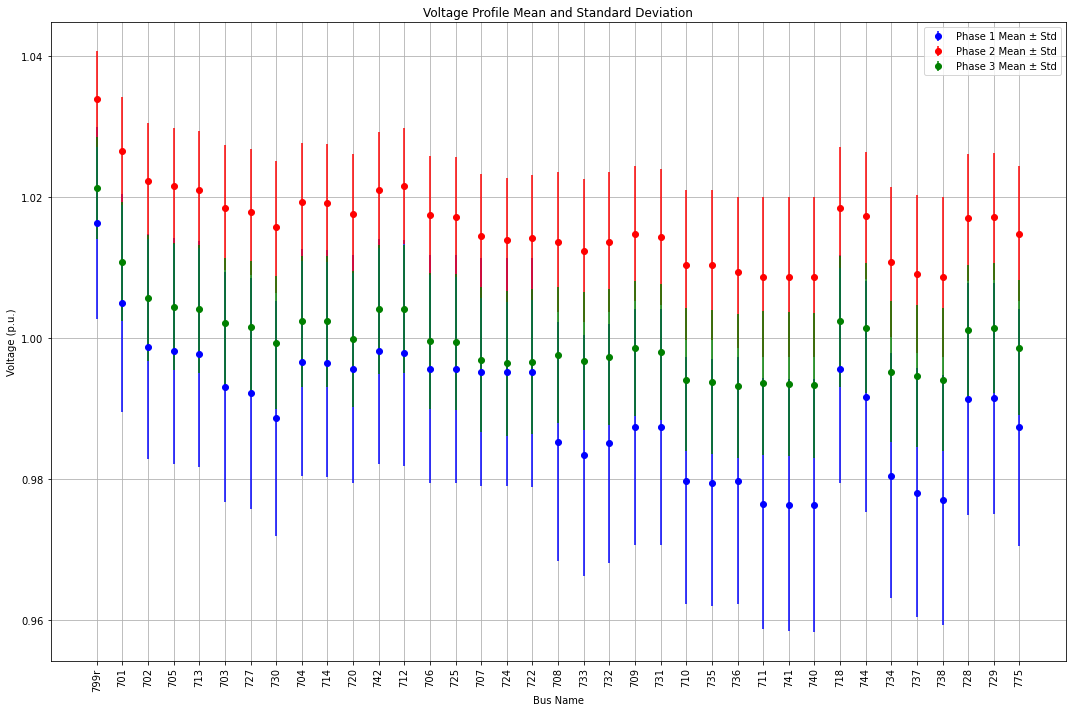

In [5]:
import numpy as np
from opendssdirect import dss
import os
import matplotlib.pyplot as plt
import json

class VoltageProfileSimulator:
    def __init__(self, dss_file, line_data_file, output_dir="results"):
        self.dss_file = dss_file
        self.line_data_file = line_data_file
        self.output_dir = output_dir
        self.load_data = []
        self.bus_names = []
        self.P_scenarios = {}
        self.Q_scenarios = {}
        self.bus_voltages = []
        self.buses, self.phases, self.bus_index = [], [], {}
        os.makedirs(self.output_dir, exist_ok=True)
        
    def load_system(self):
        """Load the DSS system file and solve the power flow."""
        dss.run_command(f'Redirect "{self.dss_file}"')
        dss.Solution.Solve()

    def load_line_data_from_json(self):
        """Load line data from a JSON file."""
        with open(self.line_data_file, 'r') as file:
            line_data = json.load(file)
        return line_data

    def extract_buses_and_phases(self, line_data):
        """Extract bus names and phases from line data."""
        buses = []
        phases = {'1', '2', '3'}
        seen_buses = set()
        for line_info in line_data.values():
            bus1_base = line_info['FromBus'].split('.')[0]
            bus2_base = line_info['ToBus'].split('.')[0]
            if bus1_base not in seen_buses:
                buses.append(bus1_base)
                seen_buses.add(bus1_base)
            if bus2_base not in seen_buses:
                buses.append(bus2_base)
                seen_buses.add(bus2_base)
        bus_index = {bus: i for i, bus in enumerate(buses)}
        self.buses = buses
        self.phases = phases
        self.bus_index = bus_index

    def get_bus_voltages(self):
        """Retrieve the voltage magnitudes for each bus and phase."""
        bus_voltages = {bus: {'1': None, '2': None, '3': None} for bus in self.buses}
        for bus in self.buses:
            dss.Circuit.SetActiveBus(bus)
            vmag_angle = dss.Bus.puVmagAngle()
            nodes = dss.Bus.Nodes()
            for i, node in enumerate(nodes):
                phase = str(node)
                if phase in ['1', '2', '3']:
                    index = 2 * i
                    bus_voltages[bus][phase] = vmag_angle[index]
        return bus_voltages

    def extract_load_data(self):
        """Extract load data from the DSS system."""
        loads = dss.Loads.AllNames()
        for load in loads:
            dss.Loads.Name(load)
            bus = dss.CktElement.BusNames()[0]
            phases = dss.Loads.Phases()
            conn = 'Delta' if dss.Loads.IsDelta() else 'Wye'
            P = dss.Loads.kW()
            Q = dss.Loads.kvar()
            kV = dss.Loads.kV()
            
            S = np.sqrt(P**2 + Q**2)
            power_factor = P / S

            self.load_data.append({
                'name': load,
                'bus': bus,
                'phases': phases,
                'connection': conn,
                'P': P,
                'Q': Q,
                'kV': kV,
                'power_factor': power_factor
            })
        self.bus_names = dss.Circuit.AllBusNames()
    
    def load_scenarios(self, test_case):
        """Load previously saved P and Q scenarios."""
        self.P_scenarios = np.load(os.path.join(self.output_dir, f"P_OpenDSS_uniform_{test_case}.npy"), allow_pickle=True).item()
        self.Q_scenarios = np.load(os.path.join(self.output_dir, f"Q_OpenDSS_uniform_{test_case}.npy"), allow_pickle=True).item()

    def run_scenarios(self, n_scenarios=10000):
        """Run the simulation for multiple scenarios and collect bus voltage data."""
        for scenario_idx in range(n_scenarios):
            for load in self.load_data:
                name = load['name']
                dss.Loads.Name(name)
                P_new = self.P_scenarios[name][scenario_idx]
                Q_new = self.Q_scenarios[name][scenario_idx]
                dss.Loads.kW(P_new)
                dss.Loads.kvar(Q_new)
            
            dss.Solution.Solve()
            V_scenario = self.get_bus_voltages()
            self.bus_voltages.append(V_scenario)
            dss.run_command('plot profile phases=all')

        # Convert the bus voltages to the desired JSON format
        voltage_dict = {}
        for idx, voltages in enumerate(self.bus_voltages):
            scenario_key = f"scenario_{idx}"
            voltage_list = []
            for bus in self.buses:
                for phase in ['1', '2', '3']:
                    voltage = voltages[bus].get(phase, 0) if voltages[bus].get(phase) is not None else 0
                    voltage_list.append(voltage)
            voltage_dict[scenario_key] = voltage_list

        with open(os.path.join(self.output_dir, f"{TestCase}_uniform_voltages.json"), 'w') as file:
            json.dump(voltage_dict, file, indent=4)

        return self.bus_voltages

    def plot_voltage_profiles(self):
        """Plot the voltage profiles for all scenarios."""
        bus_voltages_array = np.array([
            [
                [
                    scenario[bus].get(str(phase), 0) if scenario[bus].get(str(phase)) is not None else 0
                    for phase in range(1, 4)
                ]
                for bus in self.buses
            ]
            for scenario in self.bus_voltages
        ], dtype=float)

        valid_buses_mask = ~np.all(bus_voltages_array == 0, axis=(0, 2))
        valid_bus_names = np.array(self.buses)[valid_buses_mask]
        valid_bus_voltages = bus_voltages_array[:, valid_buses_mask, :]

        non_empty_slices_mask = ~np.all(valid_bus_voltages == 0, axis=(0, 2))
        filtered_bus_voltages = valid_bus_voltages[:, non_empty_slices_mask, :]
        filtered_bus_names = valid_bus_names[non_empty_slices_mask]

        if filtered_bus_voltages.size == 0:
            print("No valid voltage data available to plot.")
            return

        V_mean = np.mean(filtered_bus_voltages, axis=0)
        V_std = np.std(filtered_bus_voltages, axis=0)

        plt.figure(figsize=(15, 10))
        phases = ['Phase 1', 'Phase 2', 'Phase 3']
        colors = ['b', 'r', 'g']
        for phase in range(3):
            plt.errorbar(filtered_bus_names, V_mean[:, phase], yerr=V_std[:, phase], fmt='o', color=colors[phase], label=f'{phases[phase]} Mean ± Std')

        plt.xlabel('Bus Name')
        plt.ylabel('Voltage (p.u.)')
        plt.title('Voltage Profile Mean and Standard Deviation')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # TestCase = '13Bus'
    TestCase = '37Bus'

    simulator = VoltageProfileSimulator(
        # dss_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TestCase}/IEEE13Nodeckt.dss",
        dss_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TestCase}/ieee37.dss",
        line_data_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TestCase}_line_data.json"
    )

    simulator.load_system()
    line_data = simulator.load_line_data_from_json()
    simulator.extract_buses_and_phases(line_data)
    simulator.extract_load_data()
    simulator.load_scenarios(TestCase)  # Load the previously saved scenarios
    bus_voltages = simulator.run_scenarios()
    simulator.plot_voltage_profiles()


# OoenDSS High Load

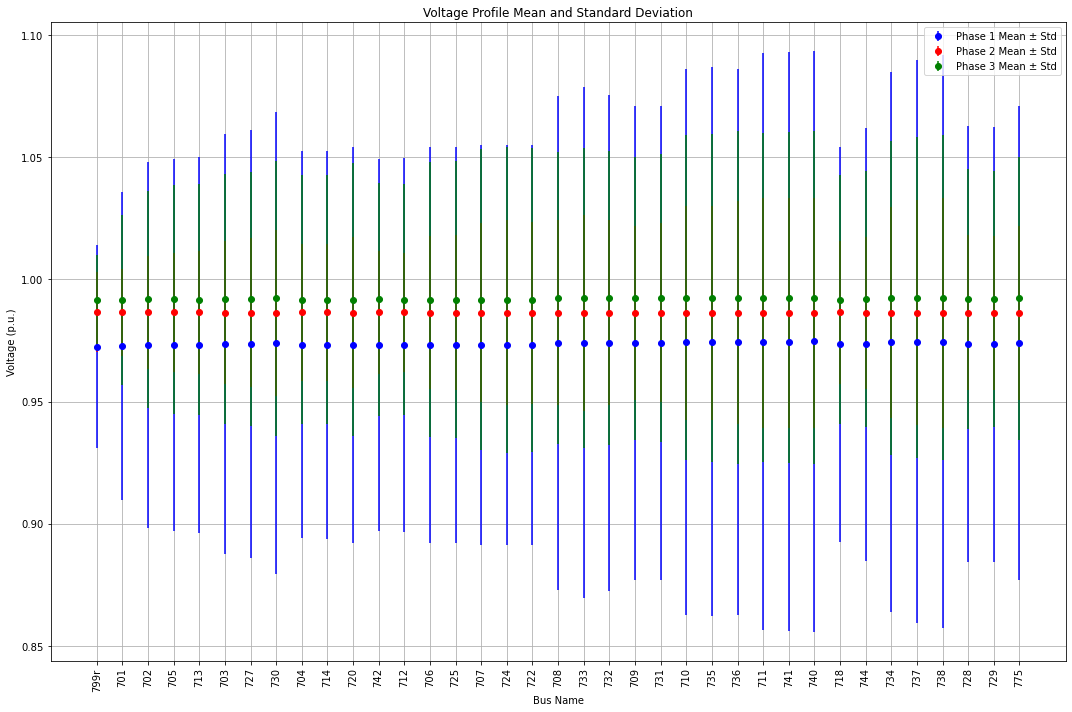

In [6]:
import numpy as np
from opendssdirect import dss
import os
import matplotlib.pyplot as plt
import json

class VoltageProfileSimulator:
    def __init__(self, dss_file, line_data_file, output_dir="results"):
        self.dss_file = dss_file
        self.line_data_file = line_data_file
        self.output_dir = output_dir
        self.load_data = []
        self.bus_names = []
        self.P_scenarios = {}
        self.Q_scenarios = {}
        self.bus_voltages = []
        self.buses, self.phases, self.bus_index = [], [], {}
        os.makedirs(self.output_dir, exist_ok=True)

    def load_system(self):
        """Load the DSS system file and solve the power flow."""
        dss.run_command(f'Redirect "{self.dss_file}"')
        dss.Solution.Solve()

    def load_line_data_from_json(self):
        """Load line data from a JSON file."""
        with open(self.line_data_file, 'r') as file:
            line_data = json.load(file)
        return line_data

    def extract_buses_and_phases(self, line_data):
        """Extract bus names and phases from line data."""
        buses = []
        phases = {'1', '2', '3'}
        seen_buses = set()
        for line_info in line_data.values():
            bus1_base = line_info['FromBus'].split('.')[0]
            bus2_base = line_info['ToBus'].split('.')[0]
            if bus1_base not in seen_buses:
                buses.append(bus1_base)
                seen_buses.add(bus1_base)
            if bus2_base not in seen_buses:
                buses.append(bus2_base)
                seen_buses.add(bus2_base)
        bus_index = {bus: i for i, bus in enumerate(buses)}
        self.buses = buses
        self.phases = phases
        self.bus_index = bus_index

    def get_bus_voltages(self):
        """Retrieve the voltage magnitudes for each bus and phase."""
        bus_voltages = {bus: {'1': None, '2': None, '3': None} for bus in self.buses}
        for bus in self.buses:
            dss.Circuit.SetActiveBus(bus)
            vmag_angle = dss.Bus.puVmagAngle()
            nodes = dss.Bus.Nodes()
            for i, node in enumerate(nodes):
                phase = str(node)
                if phase in ['1', '2', '3']:
                    index = 2 * i
                    bus_voltages[bus][phase] = vmag_angle[index]
        return bus_voltages

    def extract_load_data(self):
        """Extract load data from the DSS system."""
        loads = dss.Loads.AllNames()
        for load in loads:
            dss.Loads.Name(load)
            bus = dss.CktElement.BusNames()[0]
            phases = dss.Loads.Phases()
            conn = 'Delta' if dss.Loads.IsDelta() else 'Wye'
            P = dss.Loads.kW()
            Q = dss.Loads.kvar()
            kV = dss.Loads.kV()
            
            S = np.sqrt(P**2 + Q**2)
            power_factor = P / S

            self.load_data.append({
                'name': load,
                'bus': bus,
                'phases': phases,
                'connection': conn,
                'P': P,
                'Q': Q,
                'kV': kV,
                'power_factor': power_factor
            })
        self.bus_names = dss.Circuit.AllBusNames()
    
    def load_scenarios(self, test_case):
        """Load previously saved P and Q scenarios."""
        self.P_scenarios = np.load(os.path.join(self.output_dir, f"P_high_load_{test_case}.npy"), allow_pickle=True).item()
        self.Q_scenarios = np.load(os.path.join(self.output_dir, f"Q_high_load_{test_case}.npy"), allow_pickle=True).item()

    def run_scenarios(self, n_scenarios=30):
        """Run the simulation for multiple scenarios and collect bus voltage data."""
        for scenario_idx in range(n_scenarios):
            for load in self.load_data:
                name = load['name']
                dss.Loads.Name(name)
                P_new = self.P_scenarios[name][scenario_idx]
                Q_new = self.Q_scenarios[name][scenario_idx]
                dss.Loads.kW(P_new)
                dss.Loads.kvar(Q_new)
            
            dss.Solution.Solve()
            V_scenario = self.get_bus_voltages()
            self.bus_voltages.append(V_scenario)
            dss.run_command('plot profile phases=all')

        # Convert the bus voltages to the desired JSON format
        voltage_dict = {}
        for idx, voltages in enumerate(self.bus_voltages):
            scenario_key = f"scenario_{idx}"
            voltage_list = []
            for bus in self.buses:
                for phase in ['1', '2', '3']:
                    voltage = voltages[bus].get(phase, 0) if voltages[bus].get(phase) is not None else 0
                    voltage_list.append(voltage)
            voltage_dict[scenario_key] = voltage_list

        # Save the bus voltages to a JSON file
        with open(os.path.join(self.output_dir, f"{TestCase}_High_voltages.json"), 'w') as file:
            json.dump(voltage_dict, file, indent=4)

        return self.bus_voltages

    def plot_voltage_profiles(self):
        """Plot the voltage profiles for all scenarios."""
        bus_voltages_array = np.array([
            [
                [
                    scenario[bus].get(str(phase), 0) if scenario[bus].get(str(phase)) is not None else 0
                    for phase in range(1, 4)
                ]
                for bus in self.buses
            ]
            for scenario in self.bus_voltages
        ], dtype=float)

        # Filter out buses with all zero values in all scenarios
        valid_buses_mask = ~np.all(bus_voltages_array == 0, axis=(0, 2))
        valid_bus_names = np.array(self.buses)[valid_buses_mask]
        valid_bus_voltages = bus_voltages_array[:, valid_buses_mask, :]

        # Further filter to avoid empty slices for mean and std calculations
        non_empty_slices_mask = ~np.all(valid_bus_voltages == 0, axis=(0, 2))
        filtered_bus_voltages = valid_bus_voltages[:, non_empty_slices_mask, :]
        filtered_bus_names = valid_bus_names[non_empty_slices_mask]

        if filtered_bus_voltages.size == 0:
            print("No valid voltage data available to plot.")
            return

        V_mean = np.mean(filtered_bus_voltages, axis=0)
        V_std = np.std(filtered_bus_voltages, axis=0)

        plt.figure(figsize=(15, 10))
        phases = ['Phase 1', 'Phase 2', 'Phase 3']
        colors = ['b', 'r', 'g']
        for phase in range(3):
            plt.errorbar(filtered_bus_names, V_mean[:, phase], yerr=V_std[:, phase], fmt='o', color=colors[phase], label=f'{phases[phase]} Mean ± Std')

        plt.xlabel('Bus Name')
        plt.ylabel('Voltage (p.u.)')
        plt.title('Voltage Profile Mean and Standard Deviation')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    TestCase = '37Bus'
    # TestCase = '13Bus'

    simulator = VoltageProfileSimulator(
        # dss_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TestCase}/IEEE13Nodeckt.dss",
        dss_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TestCase}/ieee37.dss",
        line_data_file=f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TestCase}_line_data.json"
    )

    simulator.load_system()
    line_data = simulator.load_line_data_from_json()
    simulator.extract_buses_and_phases(line_data)
    simulator.extract_load_data()
    simulator.load_scenarios(TestCase)  # Load the previously saved scenarios
    bus_voltages = simulator.run_scenarios()
    simulator.plot_voltage_profiles()
